# ECHOSIS

In [1]:
import polars as pl
from plotnine import ggplot, geom_point, geom_col, geom_line, aes, scale_color_identity, labs, theme, element_text, scale_x_datetime, scale_x_discrete, theme_minimal, facet_wrap, guides, geom_smooth, coord_flip, geom_text, scale_x_continuous, geom_segment
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np

#### The youtuber to be analyzed

In [2]:
video_file = "./corpus/tatiana_ventose_videos.csv"
first_comment_file = "./corpus/tatiana_ventose_comments_first-comments.csv"
replies_file = "./corpus/tatiana_ventose_comments-replies.csv"
commenter_file = "./corpus/tatiana_ventose_commenters.csv"
ytb = "tatiana_ventose"
ytb_name = "Tatiana Ventôse"

In [3]:
videos = pl.read_csv(video_file).with_columns(
    pl.col('published_at').str.to_datetime(),
    pl.col('duration').str.replace_all("^PT([0-9]{1,2})S$", "00:00:$1").str.replace_all("^PT([0-9]{1,2})M([0-9]{1,2})S$", "00:$1:$2").str.replace_all("^PT([0-9]{1,2})H([0-9]{1,2})M([0-9]{1,2})S$", "$1:$2:$3").str.replace_all("^PT([0-9]{1,2})M$", "00:$1:00").str.to_time("%H:%M:%S"),
    pl.col("tags").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("gensim_topics").str.split(by="|"),
    pl.col("comment_count").fill_null(-1),
    pl.col("view_count").fill_null(-1),
    pl.col("like_count").fill_null(-1)
)

In [4]:
first_comments = pl.read_csv(first_comment_file).filter(pl.col("position") == 1)
replies = pl.read_csv(replies_file).filter(pl.col("position") > 1)
comments = pl.concat([first_comments, replies], how="vertical").with_columns(
    pl.col('published_at').str.slice(0, length=4).alias("year"),
    pl.col('updated_at').str.to_datetime(), 
    pl.col('published_at').str.to_datetime(),
    pl.col("like_count").fill_null(0),
    pl.col("reply_count").fill_null(0)
).join(
    videos.select(["video_id", "gensim_topics"]),
    on="video_id",
    how="left"
)

In [5]:
comments["toxicity"].mean()

0.1705828322991642

In [6]:
accord = comments.filter(pl.col("accord") > 0.70).height
accord

59847

In [7]:
desaccord = comments.filter(pl.col("desaccord") > 0.70).height
desaccord

99840

In [8]:
ambigue = comments.filter(pl.col("ambigue") > 0.70).height
ambigue

57760

In [9]:
accord+desaccord+ambigue

217447

In [10]:
total = comments.height
total

233442

In [11]:
commenters = pl.read_csv(commenter_file).with_columns(
        pl.col('published_at').str.to_datetime(),
    pl.col("description").str.replace_all("^$", "Not_provided"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("keywords").fill_null("Not_provided").str.split(by="|"),
)

## length of the comments

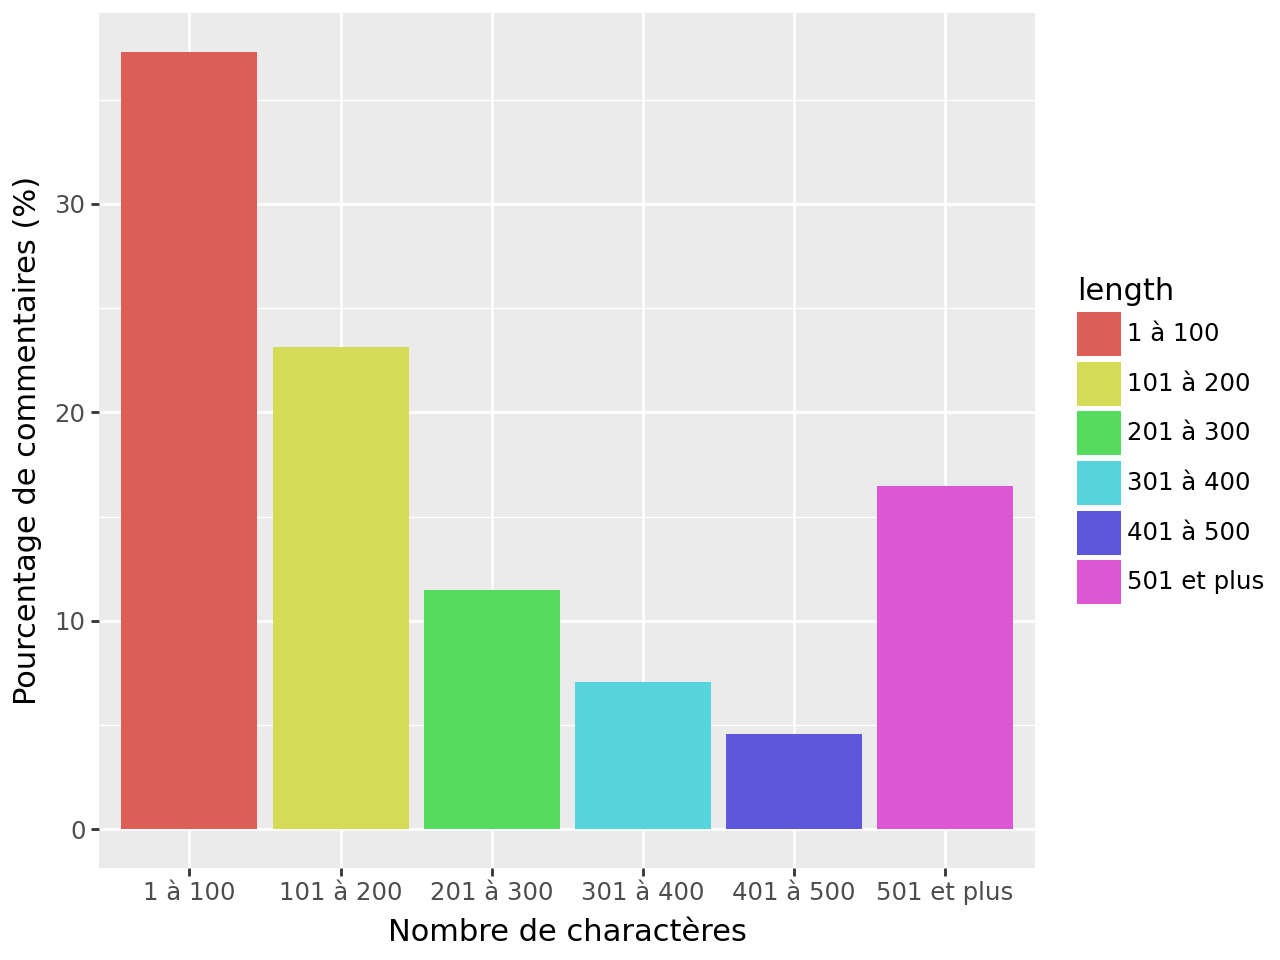

/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: longueur.jpeg


In [12]:
df = comments.with_columns(
    pl.col("text").str.split("").list.len()
).with_columns(
    pl.when(pl.col("text") <= 100).then(pl.lit("1 à 100"))
    .when(pl.col("text") <= 200).then(pl.lit("101 à 200"))
    .when(pl.col("text") <= 300).then(pl.lit("201 à 300"))
    .when(pl.col("text") <= 400).then(pl.lit("301 à 400"))
    .when(pl.col("text") <= 500).then(pl.lit("401 à 500"))
    .otherwise(pl.lit("501 et plus")).alias("length")
).group_by(
    "length"
).agg(
    pl.col("comment_id")
).with_columns(
    ((pl.col("comment_id").list.len() / total) * 100).alias("percent_comments")
).sort("length")

p = ggplot(df, aes("length", "percent_comments", fill="length")) \
        + geom_col() \
        + labs(x="Nombre de charactères", y="Pourcentage de commentaires (%)")
p.show()
p.save('longueur.jpeg', dpi=1000)

# Agreement

## agreement by commenter

In [13]:
agreement_commenter = comments.with_columns(
    pl.when(pl.col("accord") >= 0.7)
    .then(1)
    .when(pl.col("desaccord") >= 0.7)
    .then(-1)
    .otherwise(0)
    .alias("commenter_agreement")
).group_by(
    "author_channel_id"
).agg(
    [pl.col("commenter_agreement").mean(), pl.col("commenter_agreement").len().alias("commenter_comment_count")]
).sort(["commenter_agreement", "commenter_comment_count"], descending=True)
agreement_commenter

author_channel_id,commenter_agreement,commenter_comment_count
str,f64,u32
"""UC0EVd12gHqMAYl9TksGc0Dw""",1.0,24
"""UCTXLwNmwE5gy96GryWZDBIQ""",1.0,15
"""UC8VmcfRLJ9_bDYaBqQAXj7w""",1.0,13
"""UCVUtsl5STO4EA83HiNx_LKw""",1.0,11
"""UCaJwML0nEm40ujHKNW6ey6A""",1.0,10
…,…,…
"""UCfsrV9GLYB-UTrFqLfPkprg""",-1.0,1
"""UCc6A5wmjaJxuGBIRxBqaweA""",-1.0,1
"""UCr-xI6LtwURi_AemOVP6W6Q""",-1.0,1


In [14]:
comments = comments.join(agreement_commenter, on="author_channel_id", how="left")

### exemple

In [15]:
# high agreement
agreement_commenter.filter(pl.col("commenter_agreement") >= 0.75).filter(pl.col("commenter_comment_count") >= 20).sort("commenter_comment_count")

author_channel_id,commenter_agreement,commenter_comment_count
str,f64,u32
"""UC0EVd12gHqMAYl9TksGc0Dw""",1.0,24
"""UC-VH_g0MSS9Z3FdFuRhIpwg""",0.807692,26
"""UC4_EXCFj7EXHAbo1to0g62g""",0.925926,27
"""UCy0J0y8LyhJq-QvanYaG4Lg""",0.76,50
"""UCKIzKCVBUvauQGfPV-fH_xQ""",0.935484,62


In [16]:
# low agreement
agreement_commenter.filter(pl.col("commenter_agreement") <= -0.75).filter(pl.col("commenter_comment_count") >= 20).sort("commenter_comment_count")

author_channel_id,commenter_agreement,commenter_comment_count
str,f64,u32
"""UCAyCBnP-rOipt1bK5OQRNsg""",-0.75,20
"""UCB27_GVHKe_bpIWaVzpePmg""",-0.75,20
"""UC7t_uJdY5pL4mqQ2EqONaEA""",-0.8,20
"""UCGMzvdErMkUAwhpB8yyo07A""",-0.8,20
"""UC24xbRdi9pFKFtADArhcVUg""",-0.8,20
…,…,…
"""UC4eCCanmyZ5yyFieP6ZCaDg""",-0.803922,51
"""UCkybI7JVsW0BKugPBZXhC1Q""",-0.786885,61
"""UCj7RmEK1Rv64gcgQTWefHdw""",-0.774648,71


In [17]:
# select a commentator
commenters.filter(pl.col("channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg")

channel_id,channel_title,custom_url,description,published_at,video_count,view_count,subscriber_count,topics,keywords
str,str,str,str,"datetime[μs, UTC]",i64,i64,i64,list[str],list[str]
"""UCVULMtTaLKCMv8OGjmv-Hlg""","""NabucoDinosaure""","""@nabucodinosaur""","""Voici ma dernière DemoReel d'A…",2009-09-15 16:43:06 UTC,9,2615,21,"[""Entertainment"", ""Film""]","[""Not_provided""]"


In [18]:
# show the position of his comments
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").group_by("position").agg(pl.col("published_at").len().alias("count")).sort("count").to_pandas()

,position,count
0,70,1
1,21,1
2,71,1
3,26,1
4,57,1
5,19,1
6,27,1
7,31,1
8,36,1
9,45,1


In [19]:
# show the number of comments which expressed disagreement
fci = comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg")["first_comment_id"].to_list()
comments.filter(
    (pl.col("first_comment_id").is_in(fci)) & (pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg")
).select(
    ["accord", "desaccord", "ambigue"]
).filter(pl.col("desaccord") > 0.75).height

92

In [20]:
# the videos which he commented under
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").explode("gensim_topics").group_by("video_id").agg(pl.col("published_at").len()).sort("published_at")

video_id,published_at
str,u32
"""UyA1NCoQdZ4""",1
"""RsN6rYkxeHQ""",1
"""0E2gLNymKkM""",2
"""tOExKhmKvCs""",3
"""kuMC_dL53JI""",3
…,…
"""tlZpBuKPypc""",6
"""2haycSDYKLI""",12
"""U-1yeXAr0o4""",14


In [21]:
# mean toxicity score of his comments
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").select("toxicity").mean()

toxicity
f64
0.298597


In [22]:
# mean insult score of his comments
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").select("insult").mean()

insult
f64
0.311902


In [23]:
# his first comment
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").sort("published_at").select(["text", "published_at"]).head(1)

text,published_at
str,"datetime[μs, UTC]"
"""niveau jeux vidéo aussi car ce…",2017-11-05 13:59:15 UTC


In [24]:
# his last comment
comments.filter(pl.col("author_channel_id") == "UCVULMtTaLKCMv8OGjmv-Hlg").sort("published_at", descending=True).select(["text", "published_at"]).head(1)

text,published_at
str,"datetime[μs, UTC]"
"""je suis sous le choc/mais pr l…",2021-03-05 09:38:40 UTC


## agreement by discussion

In [25]:
agreement_discussion = comments.with_columns(
    pl.when(pl.col("accord") >= 0.7)
    .then(1)
    .when(pl.col("desaccord") >= 0.7)
    .then(-1)
    .otherwise(0)
    .alias("discussion_agreement")
).group_by(
    "first_comment_id"
).agg(
    [pl.col("discussion_agreement").mean(), pl.col("discussion_agreement").len().alias("discussion_comment_count")]
).sort(["discussion_agreement", "discussion_comment_count"], descending=True)
agreement_discussion

first_comment_id,discussion_agreement,discussion_comment_count
str,f64,u32
"""UgxON8qV-qnun5yPzl94AaABAg""",1.0,9
"""Ugy1c_Nn4zlL7DeOu4p4AaABAg""",1.0,9
"""Ugz8anHni6wgyfJus814AaABAg""",1.0,7
"""UgykVKrcenFWtV_bwvB4AaABAg""",1.0,7
"""UgxIuNmGwrdAPjG-xVt4AaABAg""",1.0,7
…,…,…
"""UgxMqUNZmDValafTq154AaABAg""",-1.0,2
"""Ugyd2M6Lh4roM2uptkJ4AaABAg""",-1.0,2
"""UgwOHJLRyoFjyrj7RlN4AaABAg""",-1.0,2


In [26]:
comments = comments.join(agreement_discussion, on="first_comment_id", how="left")

# Toxicity

check correlation in the comments

In [27]:
total_results = pl.DataFrame()

In [28]:
def get_R2(df, x: str, y: str) -> float:
    """to calculate R2

    Args:
        df (pl.DataFrame): polars dataframe with element with the two distribution
        x (str): name of the first column
        y (str): name of the second column
    """
    df = df.with_columns(
        pl.col(x).log(base=10),
        pl.col(y).log(base=10)
    ).filter(
        (pl.col("total_toxic_comments").is_nan().not_()) & (pl.col("total_toxic_comments").is_infinite().not_())
    )

    total_x = df[x].to_numpy()
    total_y = df[y].to_numpy()

    mean_total_x = np.mean(total_x)
    mean_total_y = np.mean(total_y)

    SST = np.sum((total_y - mean_total_y) ** 2)
    SSR = np.sum((total_y - (mean_total_y + (total_x - mean_total_x))) ** 2)
    
    return 1 - (SSR / SST)

#### with all comments

In [29]:
results = {"titre": [], "filtre": [], "toxicity >=": [], "nombre de vidéos": [], "R2": []}
for number in [0.5, 0.6, 0.7, 0.8]:

    for topic in range(0, 21):
        df = comments.join(
            comments.group_by("video_id").agg(pl.col("comment_id").count().alias("total_comments")), 
            on="video_id"
        ).explode(
            "gensim_topics"
        ).filter(
            pl.col("gensim_topics") == str(topic)
        ).with_columns(
            pl.when(pl.col("toxicity") >= number)
            .then(1)
            .otherwise(0)
            .alias("toxicity")
        ).group_by("total_comments").agg(
            pl.col("toxicity").sum().alias("total_toxic_comments")
        ).select(
            ["total_comments", "total_toxic_comments"]
        )
        
        R2 = get_R2(df, "total_comments", "total_toxic_comments")

        results["titre"].append("Test par sujet - toutes les discussions")
        results["filtre"].append(topic)
        results["toxicity >="].append(number)
        results["nombre de vidéos"].append(df["total_comments"].len())
        results["R2"].append(R2)

gen_results = pl.DataFrame(results).filter(pl.col("R2") >= 0.80)

if gen_results.height > 1:
    total_results = pl.concat([total_results, gen_results], how="vertical")

/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: divide by zero encountered in scalar divide
/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide


#### start with agree

In [30]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("accord") >= 0.75))["comment_id"].to_list()
agree = comments.filter(pl.col("first_comment_id").is_in(first_comment_id))

In [31]:
# subjects
results = {"titre": [], "filtre": [], "toxicity >=": [], "nombre de vidéos": [], "R2": []}
for number in [0.5, 0.6, 0.7, 0.8]:

    for topic in range(0, 21):
        df = agree.join(
            agree.group_by("video_id").agg(pl.col("comment_id").count().alias("total_comments")), 
            on="video_id"
        ).explode(
            "gensim_topics"
        ).filter(
            pl.col("gensim_topics") == str(topic)
        ).with_columns(
            pl.when(pl.col("toxicity") >= number)
            .then(1)
            .otherwise(0)
            .alias("toxicity")
        ).group_by("total_comments").agg(
            pl.col("toxicity").sum().alias("total_toxic_comments")
        ).select(
            ["total_comments", "total_toxic_comments"]
        )

        R2 = get_R2(df, "total_comments", "total_toxic_comments")

        results["titre"].append("Test par sujet - premier commentaire étiqueté accord")
        results["filtre"].append(topic)
        results["toxicity >="].append(number)
        results["nombre de vidéos"].append(df["total_comments"].len())
        results["R2"].append(R2)

gen_results = pl.DataFrame(results).filter((pl.col("R2") >= 0.80) & (pl.col("R2").is_nan().not_()))

if gen_results.height > 1:
    total_results = pl.concat([total_results, gen_results], how="vertical")

/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: divide by zero encountered in scalar divide


#### start with disagree

In [32]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("desaccord") >= 0.75))["comment_id"].to_list()
disagree = comments.filter(pl.col("first_comment_id").is_in(first_comment_id))

In [33]:
# subjects
results = {"titre": [], "filtre": [], "toxicity >=": [], "nombre de vidéos": [], "R2": []}
for number in [0.5, 0.6, 0.7, 0.8]:

    for topic in range(0, 21):
        df = disagree.join(
            disagree.group_by("video_id").agg(pl.col("comment_id").count().alias("total_comments")), 
            on="video_id"
        ).explode(
            "gensim_topics"
        ).filter(
            pl.col("gensim_topics") == str(topic)
        ).with_columns(
            pl.when(pl.col("toxicity") >= number)
            .then(1)
            .otherwise(0)
            .alias("toxicity")
        ).group_by("total_comments").agg(
            pl.col("toxicity").sum().alias("total_toxic_comments")
        ).select(
            ["total_comments", "total_toxic_comments"]
        )

        R2 = get_R2(df, "total_comments", "total_toxic_comments")

        results["titre"].append("Test par sujet - premier commentaire étiqueté désaccord")
        results["filtre"].append(topic)
        results["toxicity >="].append(number)
        results["nombre de vidéos"].append(df["total_comments"].len())
        results["R2"].append(R2)

gen_results = pl.DataFrame(results).filter((pl.col("R2") >= 0.80) & (pl.col("R2").is_nan().not_()))


if gen_results.height > 1:
    total_results = pl.concat([total_results, gen_results], how="vertical")

/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_62316/1552750403.py:25: RuntimeWarning: divide by zero encountered in scalar divide


## high agreement

In [34]:
results = {"titre": [], "filtre": [], "toxicity >=": [], "nombre de vidéos": [], "R2": []}
for number in [0.5, 0.6, 0.7, 0.8]:
  
    df = comments.filter(pl.col("discussion_agreement") >= 0.75)
    total = df.height
    
    df = comments.join(
        disagree.group_by("video_id").agg(pl.col("comment_id").count().alias("total_comments")), 
        on="video_id"
    ).filter(
        pl.col("toxicity") >= number
    ).group_by("total_comments").agg(
        pl.col("toxicity").count().alias("total_toxic_comments")
    ).select(
        ["total_comments", "total_toxic_comments"]
    )

    R2 = get_R2(df, "total_comments", "total_toxic_comments")

    results["titre"].append("Test sur accord global de la discussion >= 0.75")
    results["filtre"].append("_")
    results["toxicity >="].append(number)
    results["nombre de vidéos"].append(df["total_comments"].len())
    results["R2"].append(R2)

gen_results = pl.DataFrame(results).filter((pl.col("R2") >= 0.80) & (pl.col("R2").is_nan().not_()))

if gen_results.height > 1:
    total_results = pl.concat([total_results, gen_results], how="vertical")

## high disagreement

In [35]:
results = {"titre": [], "filtre": [], "toxicity >=": [], "nombre de vidéos": [], "R2": []}
for number in [0.5, 0.6, 0.7, 0.8]:
        
    df = comments.filter(pl.col("discussion_agreement") <= -0.75)
    total = df.height
    
    df = df.join(
        disagree.group_by("video_id").agg(pl.col("comment_id").count().alias("total_comments")), 
        on="video_id"
    ).filter(
        pl.col("toxicity") >= number
    ).group_by("total_comments").agg(
        pl.col("toxicity").count().alias("total_toxic_comments")
    ).select(
        ["total_comments", "total_toxic_comments"]
    )

    R2 = get_R2(df, "total_comments", "total_toxic_comments")

    results["titre"].append("Test sur désaccord global de la discussion <= -0.75")
    results["filtre"].append(" ")
    results["toxicity >="].append(number)
    results["nombre de vidéos"].append(df["total_comments"].len())
    results["R2"].append(R2)

gen_results = pl.DataFrame(results).filter((pl.col("R2") >= 0.80) & (pl.col("R2").is_nan().not_()))

if gen_results.height > 1:
    total_results = pl.concat([total_results, gen_results], how="vertical")

## results

In [36]:
total_results.sort("R2", descending=True).to_pandas()

,titre,filtre,toxicity >=,nombre de vidéos,R2
0,Test par sujet - toutes les discussions,20,0.5,2,NaN
1,Test par sujet - toutes les discussions,20,0.6,2,NaN
2,Test par sujet - toutes les discussions,20,0.7,2,NaN
3,Test par sujet - toutes les discussions,0,0.8,11,NaN
4,Test par sujet - toutes les discussions,2,0.8,4,NaN
5,Test par sujet - toutes les discussions,8,0.8,2,NaN
6,Test par sujet - toutes les discussions,12,0.8,5,NaN
7,Test par sujet - toutes les discussions,13,0.8,2,NaN
8,Test par sujet - toutes les discussions,20,0.8,2,NaN
9,Test par sujet - premier commentaire étiqueté ...,16,0.6,6,0.993291


## Toxicity in the discussions

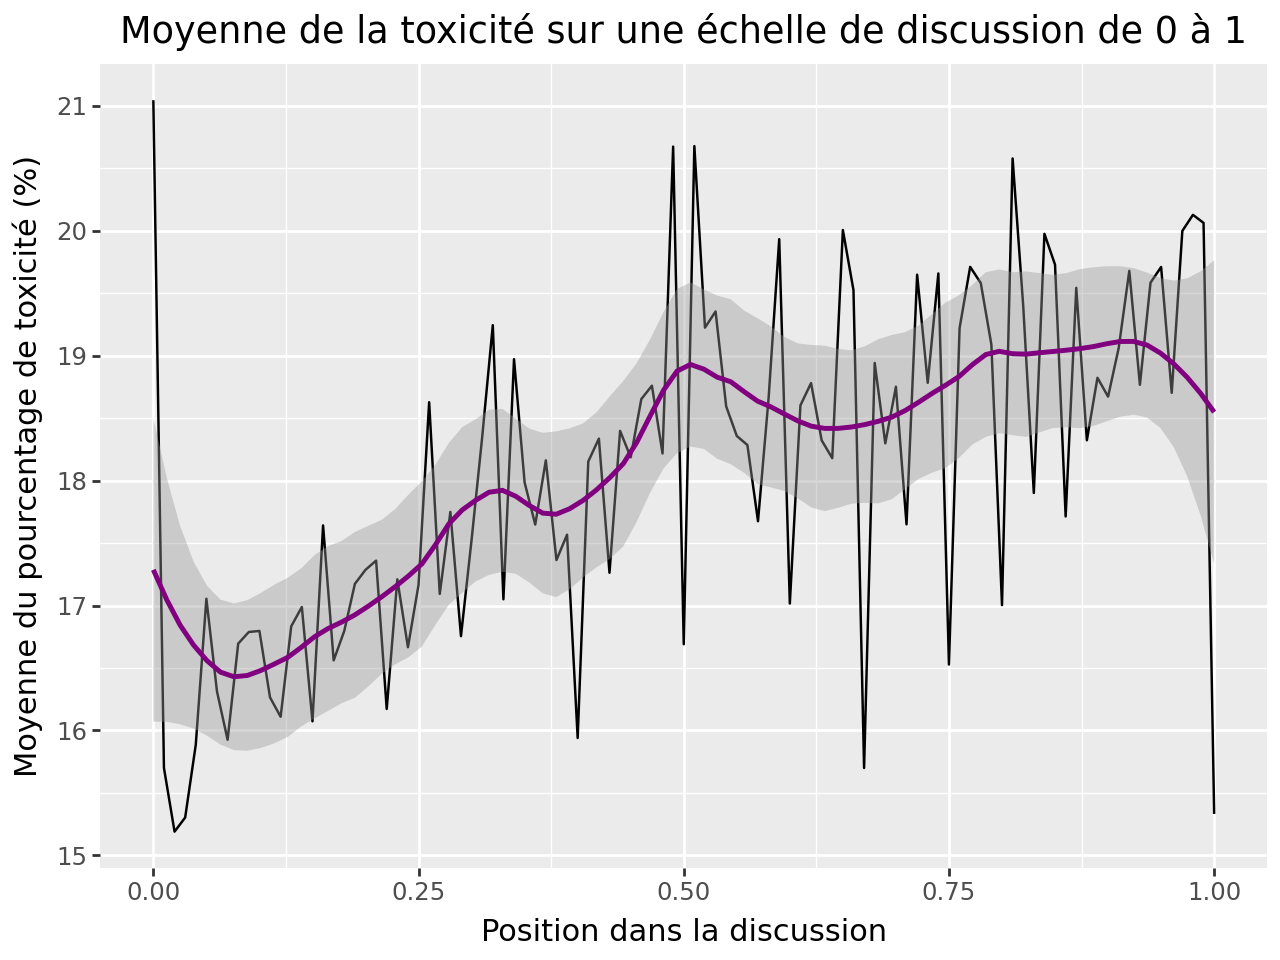

In [37]:
len_position = comments.group_by(
    "first_comment_id"
).agg(
    "position"
).with_columns(
    pl.col("position").list.len().alias("len_position")
).select(["first_comment_id", "len_position"])

df = comments.join(
    len_position, on="first_comment_id"
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(title=f"Moyenne de la toxicité sur une échelle de discussion de 0 à 1", x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.show()

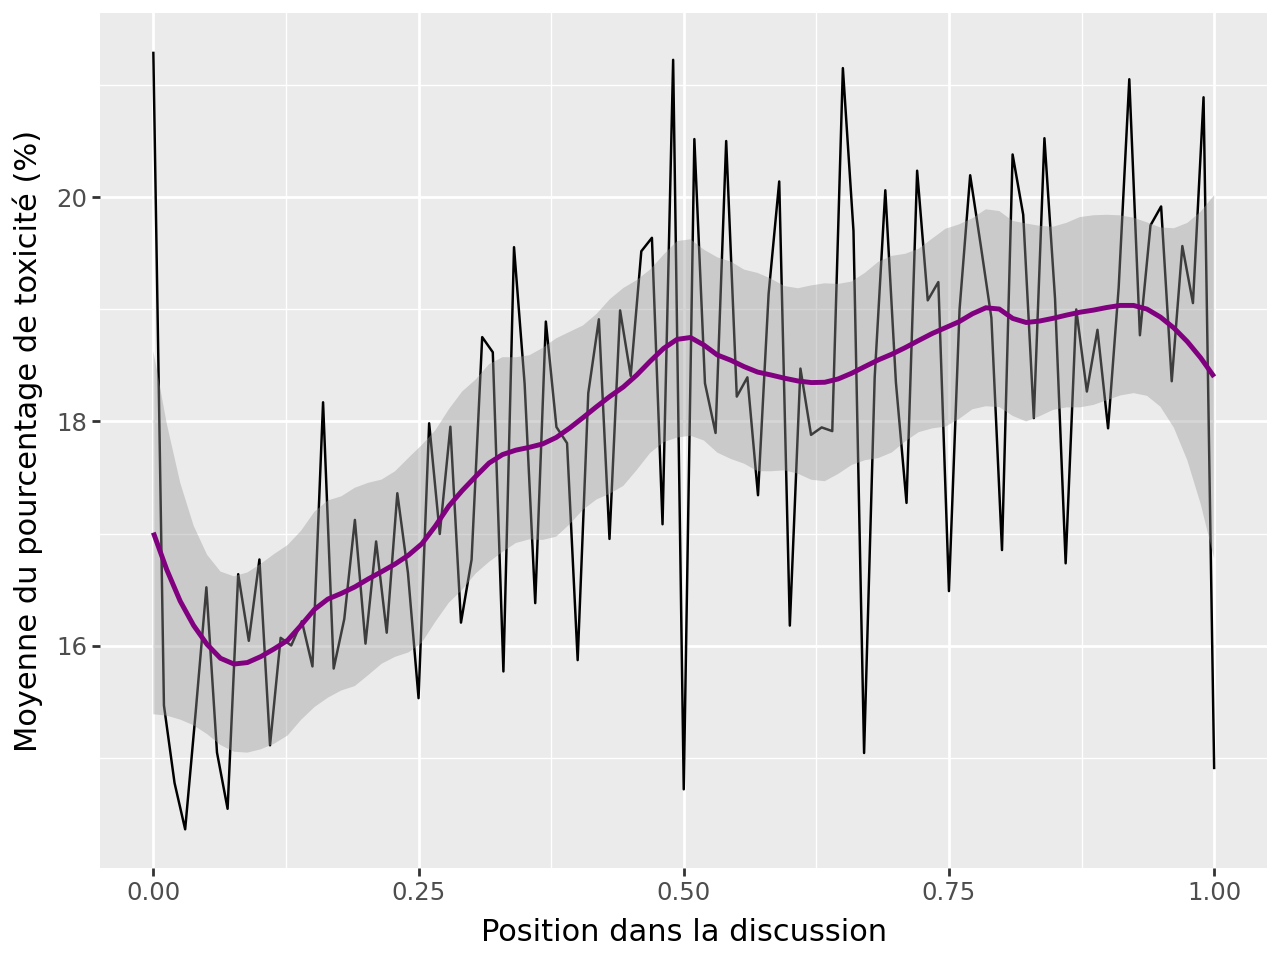

In [38]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("accord") >= 0.33))["comment_id"].to_list()

df1 = comments.join(
    len_position, on="first_comment_id"
).filter(
    pl.col("first_comment_id").is_in(first_comment_id)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df1, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.show()

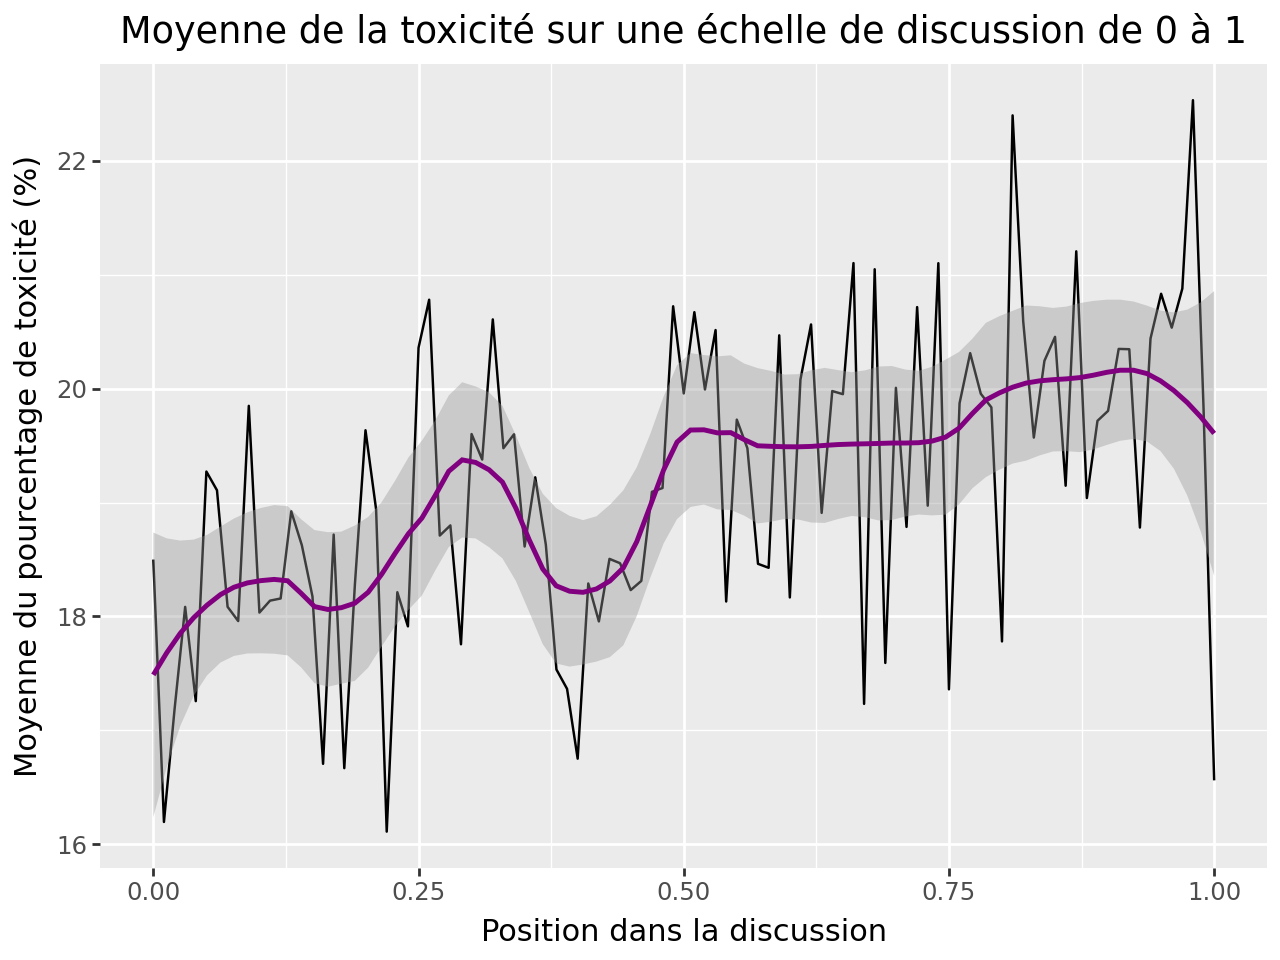

In [39]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("desaccord") >= 0.75))["comment_id"].to_list()

df1 = comments.join(
    len_position, on="first_comment_id"
).filter(
    pl.col("first_comment_id").is_in(first_comment_id)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df1, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(title=f"Moyenne de la toxicité sur une échelle de discussion de 0 à 1", x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.show()

In [40]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("discussion_agreement") <= -0.33))["comment_id"].to_list()

df1 = comments.join(
    len_position, on="first_comment_id"
).filter(
    pl.col("first_comment_id").is_in(first_comment_id)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")

p = (
    ggplot(df1, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(title=f"Moyenne de la toxicité sur une échelle de discussion de 0 à 1", x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.save("ok.png", dpi=1000)

/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/laura/miniconda3/envs/plot_visu/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ok.png


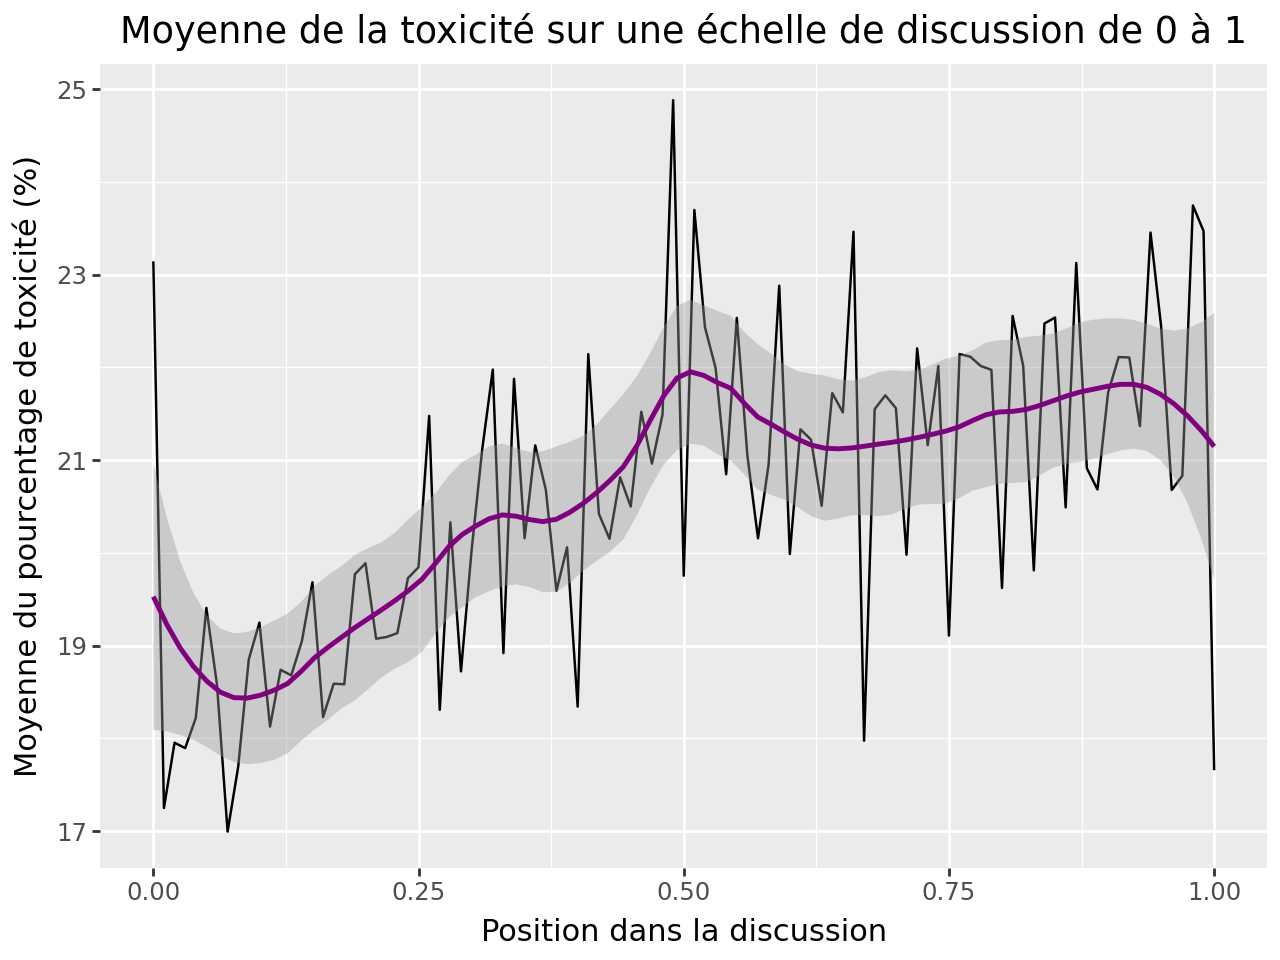

In [41]:
p.show()

In [42]:
df1["toxicity"].std()

1.6845823442245245

In [43]:
df1["toxicity"].mean()

20.618171076923996

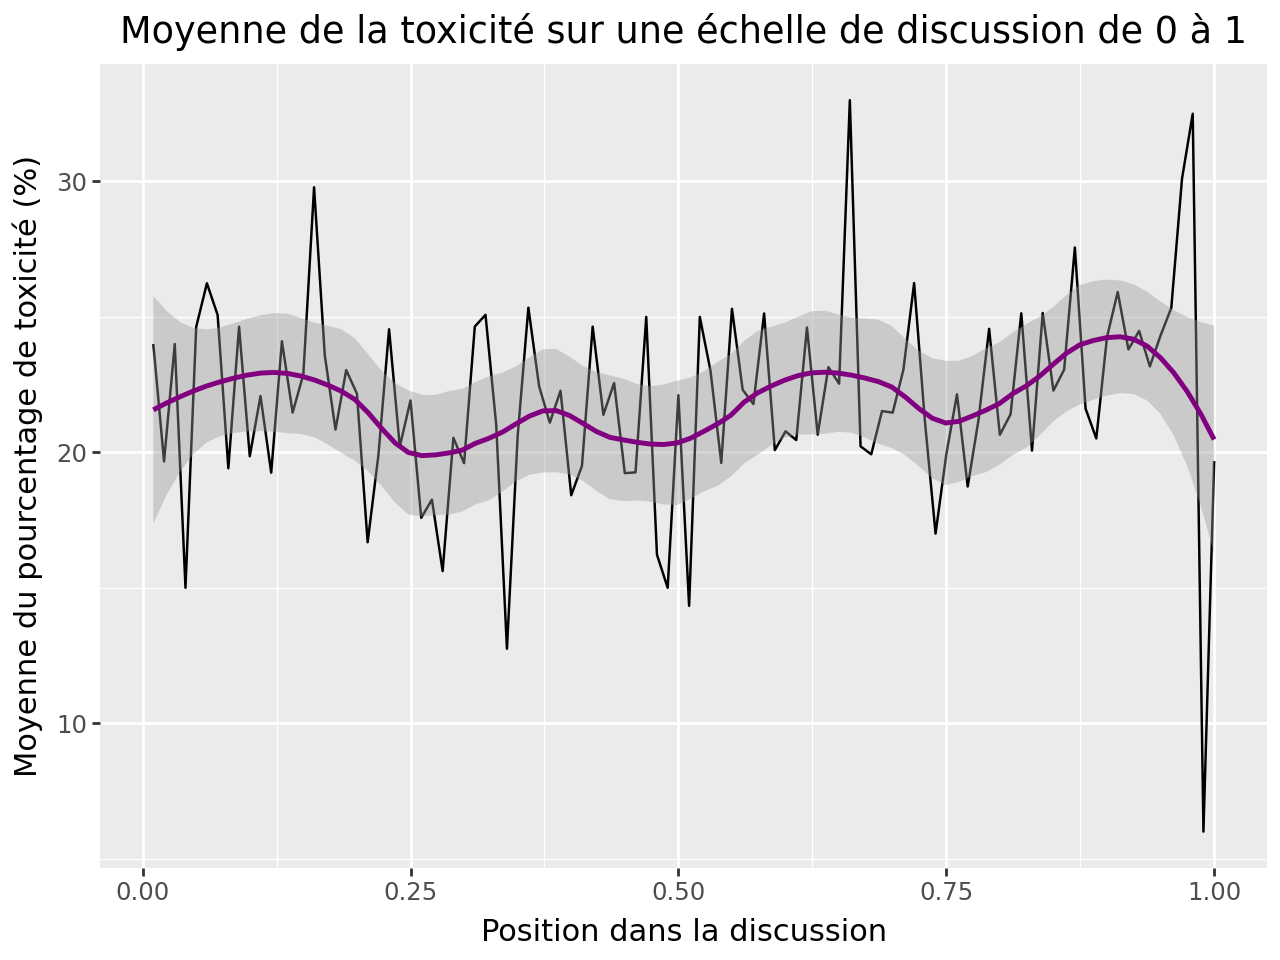

In [44]:
first_comment_id = comments.filter((pl.col("position") == 1) & (pl.col("discussion_agreement") <= -0.75))["comment_id"].to_list()

df1 = comments.join(
    len_position, on="first_comment_id"
).filter(
    pl.col("first_comment_id").is_in(first_comment_id)
).with_columns(
    (pl.col("position") / pl.col("len_position")).round(2).alias("position"),
    (pl.col("toxicity") * 100).round()
).group_by(
    pl.col("position")
).agg(
    pl.col("toxicity").mean()
).sort("position")



p = (
    ggplot(df1, aes("position", "toxicity"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + labs(title=f"Moyenne de la toxicité sur une échelle de discussion de 0 à 1", x="Position dans la discussion", y="Moyenne du pourcentage de toxicité (%)")
)
p.show()

In [45]:
df1["toxicity"].mean()

21.909593575446717

In [46]:
df1["toxicity"].std()

3.790229605581687